## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

data = pd.read_csv('data.csv')

data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

- Столбцы <b>days_employed</b> и <b>total_income</b> имеют пропущенные значения, причем их количество совпадает
- Столбец <b>days_employed</b> содержит отрицательные значения. Это поле также имеет дробные значения, что недопустимо для стажа.
- Значение в <b>столбце education</b> записаны в разных регистрах
- Значение в столбцах указаны на русском языке, однако поле gender содержит английские аббревиатуры 

### Шаг 2. Предобработка данных

### Обработка пропусков

In [3]:
data['days_employed'].isna().sum()

2174

In [4]:
data['total_income'].isna().sum()

2174

In [5]:
data[data['days_employed'].isna()]['total_income'].isna().sum()

2174

Пустые значение в обоих полях совпадают

In [6]:
data[data['days_employed'].isna()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Других закономерностей не обнаружено

In [7]:
def present(count_100_percent, count__x_percent):
    return 100/ (count_100_percent / count__x_percent)

In [8]:
present(len(data), data['days_employed'].isna().sum())

10.099883855981417

Пропущено 10% данных, довольно большой процент. Пропуски необходимо заполнить предварительно изучив и исправив значения в столбцах.

In [9]:
present(len(data), data[ data['days_employed'] < 0]['days_employed'].count())

73.89547038327527

Почти все значения отрицательные, скорее всего, ошибка заполнения.

In [10]:
data['days_employed'] = abs(data['days_employed'])

In [11]:
data.loc[data['days_employed'].notna(),'days_employed'] = data[data['days_employed'].notna()]['days_employed'].astype('int')

In [12]:
data['max_days_employed'] = (data['dob_years'] - 12) * 365.25 
def count_present_live_less_than_job(): 
    live_less_than_job = data.loc[data['max_days_employed'] < data['days_employed']]['days_employed'].count()
    return present(len(data), live_less_than_job)

In [13]:
count_present_live_less_than_job()

16.362369337979093

По закону, люди могут работать только с 12 лет. Трудовой стаж больше периода, в течении которого, человек может работать - ошибка. Таких 16.3 процента.

In [14]:
data.drop(data.loc[data['max_days_employed'] < data['days_employed']].index,inplace=True)
count_present_live_less_than_job()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  


0.0

In [15]:
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].median())
count_present_live_less_than_job()

0.05554629783924902

In [16]:
data.drop(data.loc[data['max_days_employed'] < data['days_employed']].index,inplace=True)
count_present_live_less_than_job()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in long_scalars
  


0.0

#### Поле total_income

In [17]:
data.groupby('income_type')['total_income'].mean()

income_type
в декрете           53829.130729
госслужащий        171008.225815
компаньон          202483.482019
пенсионер                    NaN
предприниматель    499163.144947
сотрудник          161390.227204
студент             98201.625314
Name: total_income, dtype: float64

Доход пенсионеров не заполнен вообще

In [18]:
mean_by_income_type = data.groupby('income_type')['total_income'].transform('mean')

In [19]:
data['total_income'] = data['total_income'].fillna(mean_by_income_type)

Остались пенсионеры для них среднее не опреденено. Смоделируем доход с помощью нормального распределения со средним значением пенсии 14 904 и дисперсией 5 000.

In [20]:
import random
data['total_income'] = data['total_income'].fillna(random.normalvariate(14904, 5000))

In [21]:
data.groupby('income_type')['total_income'].mean()

income_type
в декрете           53829.130729
госслужащий        171008.225815
компаньон          202483.482019
пенсионер           16533.177381
предприниматель    499163.144947
сотрудник          161390.227204
студент             98201.625314
Name: total_income, dtype: float64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17993 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           17993 non-null  int64  
 1   days_employed      17993 non-null  float64
 2   dob_years          17993 non-null  int64  
 3   education          17993 non-null  object 
 4   education_id       17993 non-null  int64  
 5   family_status      17993 non-null  object 
 6   family_status_id   17993 non-null  int64  
 7   gender             17993 non-null  object 
 8   income_type        17993 non-null  object 
 9   debt               17993 non-null  int64  
 10  total_income       17993 non-null  float64
 11  purpose            17993 non-null  object 
 12  max_days_employed  17993 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.9+ MB


### Вывод

Два поля содержали пустые значения (<b>days_employed</b> и <b>total_income</b>). Поле <b>days_employe</b> содержало записи, где трудовой стаж превышал период, в течении которого, человек может работать, такие данные были удалены. Пустые значения заменены на медиану, так — как трудовой стаж в днях — это переменная целого типа, тогда как средние может быть дробным (считая вещественную часть ошибкой при выгрузки данных). Для замены пустых значений в поле  <b>total_income</b>, данные были сгруппированы по полю <b>income_type</b> так, как средняя зарплата студента существенно отличается от средней предпринимателя. Пустые значения заменены  средним из соответствующей категории.

### Замена типа данных

In [23]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,max_days_employed
0,1,8437.0,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,10957.50
1,1,4024.0,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,8766.00
2,0,5623.0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,7670.25
3,3,4124.0,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,7305.00
5,0,926.0,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,5478.75


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17993 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           17993 non-null  int64  
 1   days_employed      17993 non-null  float64
 2   dob_years          17993 non-null  int64  
 3   education          17993 non-null  object 
 4   education_id       17993 non-null  int64  
 5   family_status      17993 non-null  object 
 6   family_status_id   17993 non-null  int64  
 7   gender             17993 non-null  object 
 8   income_type        17993 non-null  object 
 9   debt               17993 non-null  int64  
 10  total_income       17993 non-null  float64
 11  purpose            17993 non-null  object 
 12  max_days_employed  17993 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 1.9+ MB


In [25]:
data['days_employed'] = data['days_employed'].astype('int')

In [26]:
data['debt'].unique()

array([0, 1])

In [27]:
data['debt'] = data['debt'].astype('bool')

In [28]:
data['max_days_employed'] = data['max_days_employed'].astype('int')

### Вывод

Столбцам, содержащим количество дней, присвоен тип <b>int</b> — целое число, а столбцу <b>debt</b> тип <b>bool</b>, который более точно отражает значение поля.

### Обработка дубликатов

#### Поле children

In [29]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [30]:
present(len(data), data[ data['children'] == -1]['children'].count())

0.22230867559606515

Ошибка заполнения

In [31]:
data.loc[data['children'] == -1,'children'] = 1

In [32]:
data['children'].unique()

array([ 1,  0,  3,  2,  4, 20,  5])

#### Поле education

In [33]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'], dtype=object)

In [34]:
data['education'] = data['education'].str.lower()

In [35]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

#### Поле education_id

In [36]:
data['education_id'].unique()

array([0, 1, 2, 3, 4])

In [37]:
data.groupby('education')['education_id'].mean()

education
высшее                 0
начальное              3
неоконченное высшее    2
среднее                1
ученая степень         4
Name: education_id, dtype: int64

Средние разные и целые, следовательно, поле не содержит ошибок

#### Поле family_status

In [38]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'в разводе',
       'Не женат / не замужем', 'вдовец / вдова'], dtype=object)

In [39]:
data['family_status'] = data['family_status'].str.lower()

In [40]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'в разводе',
       'не женат / не замужем', 'вдовец / вдова'], dtype=object)

#### Поле family_status_id

In [41]:
data.groupby('family_status')['family_status_id'].mean()

family_status
в разводе                3
вдовец / вдова           2
гражданский брак         1
женат / замужем          0
не женат / не замужем    4
Name: family_status_id, dtype: int64

Средние разные и целые, следовательно, поле не содержит ошибок

#### Поле gender

In [42]:
data['gender'].value_counts()

F      11370
M       6622
XNA        1
Name: gender, dtype: int64

Скорее всего, XNA - это пустое значение. Заменим его на M, так как мужчин  меньше

In [43]:
data['gender'] = data['gender'].replace('XNA','M')

In [44]:
data['gender'].value_counts()

F    11370
M     6623
Name: gender, dtype: int64

#### Поле income_type

In [45]:
data['income_type'].unique()

array(['сотрудник', 'компаньон', 'пенсионер', 'госслужащий',
       'предприниматель', 'студент', 'в декрете'], dtype=object)

<b>Остальные поля рассмотрены ранее</b>

### Вывод

Каждое поле было изучено и обработано отдельно, в соответствии с ошибкой в нем

### Лемматизация

In [46]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'операции с жильем', 'образование',
       'на проведение свадьбы', 'покупка жилья для семьи',
       'покупка недвижимости', 'покупка коммерческой недвижимости',
       'сыграть свадьбу', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку своего автомобиля',
       'на покупку подержанного автомобиля',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'операции с коммерческой недвижимостью', 'свой автомобиль',
       'сделка с автомобилем', 'профильное образование',
       'высшее об

In [47]:
from pymystem3 import Mystem
m = Mystem()

data['purpose_lemm'] = data['purpose'].apply(m.lemmatize)

In [48]:
data['purpose_lemm'].head()

0                 [покупка,  , жилье, \n]
1       [приобретение,  , автомобиль, \n]
2                 [покупка,  , жилье, \n]
3    [дополнительный,  , образование, \n]
5                 [покупка,  , жилье, \n]
Name: purpose_lemm, dtype: object

In [49]:
def categorization(list_lemms):
    if 'образование' in list_lemms:
        return 'образование'
    if 'свадьба' in list_lemms:
        return 'свадьба'
    if 'ремонт' in list_lemms:
        return 'ремонт'
    if 'автомобиль' in list_lemms:
        return 'покупка автомобиля'
    if 'строительство' in list_lemms:
        return 'строительство'
    """
    if 'покупка' in list_lemms:
        if 'жилье' or 'недвижимость' in list_lemms:
            return 'покупка недвижимости'
    """
    return 'операции с недвижимостью'

In [50]:
data['categories'] = data['purpose_lemm'].apply(categorization)

In [51]:
data[data['categories'].isna()]['purpose'].unique()

array([], dtype=object)

### Вывод

Входе лемматизации цени кредита были укрупнены, в соответствии, со смыслом.

### Категоризация данных

#### Группировка по наличию детей

In [52]:
def with_child_or_not(children):
    if children > 0:
        return 'с детьми'
    return 'бездетные'

In [53]:
data['with_child_or_not'] = data['children'].apply(with_child_or_not)

#### Группировка по наличию сожителя

In [54]:
data.groupby('family_status')['family_status_id'].mean().reset_index().sort_values(['family_status_id'])

,family_status,family_status_id
3,женат / замужем,0
2,гражданский брак,1
1,вдовец / вдова,2
0,в разводе,3
4,не женат / не замужем,4


In [55]:
def married(family_status_id):
    if family_status_id < 2:
        return 'в браке'
    return 'одинок'    

In [56]:
data['married'] = data['family_status_id'].apply(married)

#### Группировка по уровню дохода

In [57]:
def income_level(income):
    if income < 60000:
        return 'ниже среднего'
    if income < 120000:
        return 'средний класс'
    if income < 200000:
        return 'выше среднего'
    return 'богатые'

In [58]:
data['income_level'] = data['total_income'].apply(income_level)

### Вывод

Для ответа на поставленные вопросы, данные были сгруппированы по наличию детей, семейному положению и уровню дохода.

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [59]:
pivot_children = pd.pivot_table(data, values=['income_level'], index='with_child_or_not', columns='debt', aggfunc='count')

In [60]:
pivot_children = pivot_children.reset_index()

In [61]:
pivot_children

with_child_or_not income_level     
debt                          False True
0            бездетные        10049  892
1             с детьми         6392  660

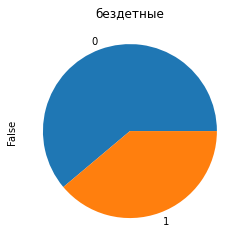

In [62]:

pivot_children['income_level'][0].plot(kind='pie', y='income_level', title='бездетные')

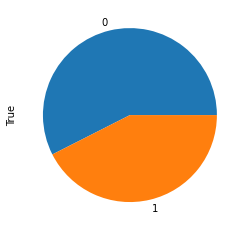

In [63]:
pivot_children['income_level'][1].plot(kind='pie', y='income_level')

### Вывод

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

### Вывод

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

### Вывод

- Как разные цели кредита влияют на его возврат в срок?

### Вывод

### Шаг 4. Общий вывод

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [ ]  файл изучен;
- [ ]  определены пропущенные значения;
- [ ]  заполнены пропущенные значения;
- [ ]  есть пояснение, какие пропущенные значения обнаружены;
- [ ]  описаны возможные причины появления пропусков в данных;
- [ ]  объяснено, по какому принципу заполнены пропуски;
- [ ]  заменен вещественный тип данных на целочисленный;
- [ ]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [ ]  удалены дубликаты;
- [ ]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [ ]  описаны возможные причины появления дубликатов в данных;
- [ ]  выделены леммы в значениях столбца с целями получения кредита;
- [ ]  описан процесс лемматизации;
- [ ]  данные категоризированы;
- [ ]  есть объяснение принципа категоризации данных;
- [ ]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [ ]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [ ]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [ ]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [ ]  в каждом этапе есть выводы;
- [ ]  есть общий вывод.